# **IMPORTS**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from PIL import Image
import os

2025-05-26 22:40:04.395296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 22:40:04.401646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748292004.408892 2433382 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748292004.411113 2433382 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748292004.416763 2433382 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# **CARGAR DATOS**


In [2]:
csv_path = '/home/quirogaalu/TFG/labels_regresion_5.csv'
df = pd.read_csv(csv_path)

In [3]:
# Filtrar datasets según el path para mantener partición
train_df = df[df['ruta_imagen'].str.contains('train_processed')]
val_df = df[df['ruta_imagen'].str.contains('valid_processed')]
test_df = df[df['ruta_imagen'].str.contains('test_processed')]

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

Train: 428, Val: 35, Test: 37


In [9]:
'''
# División de datos
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=33)  # 70% train, 30% restante

# Dividir val y test al 50% cada uno (15% y 15% del total)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=33)

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')
'''

"\n# División de datos\ntrain_df, temp_df = train_test_split(df, test_size=0.3, random_state=33)  # 70% train, 30% restante\n\n# Dividir val y test al 50% cada uno (15% y 15% del total)\nval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=33)\n\nprint(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')\n"

# **GENERAR CONJUNTOS** *TRAIN/VAL/TEST*

In [4]:
IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


# **MODELOS DE REGRESIÓN**

## MobileNetV2

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True  # Activamos fine-tuning

'''
# Opcional: congelar las primeras capas para estabilidad
for layer in base_model.layers[:80]:
    layer.trainable = False
'''

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='mse',
    metrics=['mae']
)

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

/tmp/ipykernel_2252161/1438391765.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(
I0000 00:00:1748116627.768236 2252161 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748116627.769462 2252161 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748116628.895869 2252308 service.cc:152] XLA service 0x7aa23c03c840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748116628.895884 2252308 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1748116630.695478 2252308 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 20, 20, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

model.predict(np.zeros((1, IMG_SIZE, IMG_SIZE, 3))) # Warm up

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/200


2025-05-24 21:57:20.566146: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:20.731732: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:21.236714: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:21.462219: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:21.893665: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18588.7715 - mae: 123.9444

2025-05-24 21:57:40.271676: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:40.434338: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:40.912606: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:41.138271: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 21:57:41.564507: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - loss: 18589.9160 - mae: 123.9492 - val_loss: 18265.6133 - val_mae: 121.1773 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 17512.5312 - mae: 118.1098 - val_loss: 18287.3633 - val_mae: 121.2600 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 16607.3223 - mae: 115.6715 - val_loss: 18190.1523 - val_mae: 120.8842 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 14807.0283 - mae: 108.2904 - val_loss: 17816.1953 - val_mae: 119.3578 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 14719.2939 - mae: 107.8137 - val_loss: 17378.2812 - val_mae: 117.5193 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 12898.7295 - mae: 98.3623 - val_loss: 16862.3711 - val_mae: 115.3332 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/ste

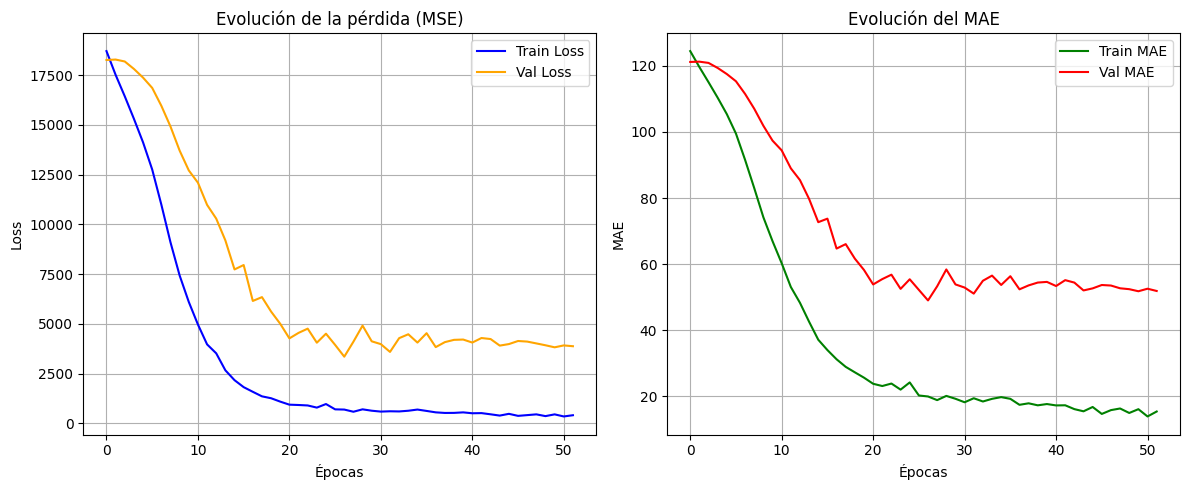

In [7]:
# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2025-05-24 22:03:33.452487: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:03:33.756978: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:03:35.300473: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:03:35.537587: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:03:36.186933: E external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 1:01 62s/step

2025-05-24 22:04:32.991085: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:04:33.165175: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:04:33.704670: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:04:33.933212: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 22:04:34.376618: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step
MAE: 50.78 | MSE: 3863.03 | R²: -0.19


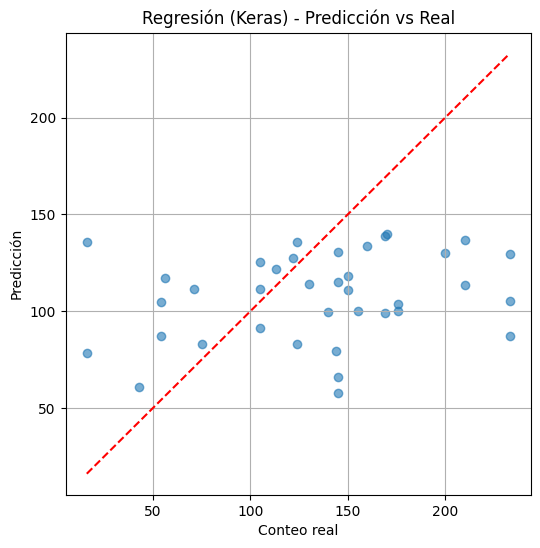

In [8]:
_ = model.predict(np.zeros_like(x_test[:1]))

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [25]:
MODEL_PATH = '/home/quirogaalu/TFG/models/MobileNetV2.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/MobileNetV2.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/MobileNetV2.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/MobileNetV2.keras


## EfficientNetB5

I0000 00:00:1748292146.536529 2433382 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21824 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748292146.537716 2433382 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748292149.421794 2433541 service.cc:152] XLA service 0x78d0140b5fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748292149.421812 2433541 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748292149.421814 2433541 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-26 22:42:29.515932: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1748292154.943634 2433541 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 20, 20, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,775,928 (109.77 MB)

 Trainable params: 28,603,185 (109.11 MB)

 Non-trainable params: 172,743 (674.78 KB)

Epoch 1/200


2025-05-26 22:43:04.655251: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:43:04.805261: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:43:05.481884: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:43:05.718195: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:43:06.277743: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 127.4517 - mae: 127.4517

2025-05-26 22:43:59.995372: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:44:00.144835: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:44:00.779132: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:44:01.017156: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 22:44:01.566745: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 91s 292ms/step - loss: 127.4307 - mae: 127.4307 - val_loss: 121.2342 - val_mae: 121.2342 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - loss: 123.3136 - mae: 123.3136 - val_loss: 121.4480 - val_mae: 121.4480 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 119.9418 - mae: 119.9418 - val_loss: 121.0834 - val_mae: 121.0834 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 110.6014 - mae: 110.6014 - val_loss: 120.8420 - val_mae: 120.8420 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - loss: 107.5293 - mae: 107.5293 - val_loss: 120.6918 - val_mae: 120.6918 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - loss: 103.7887 - mae: 103.7887 - val_loss: 120.5068 - val_mae: 120.5068 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - loss: 

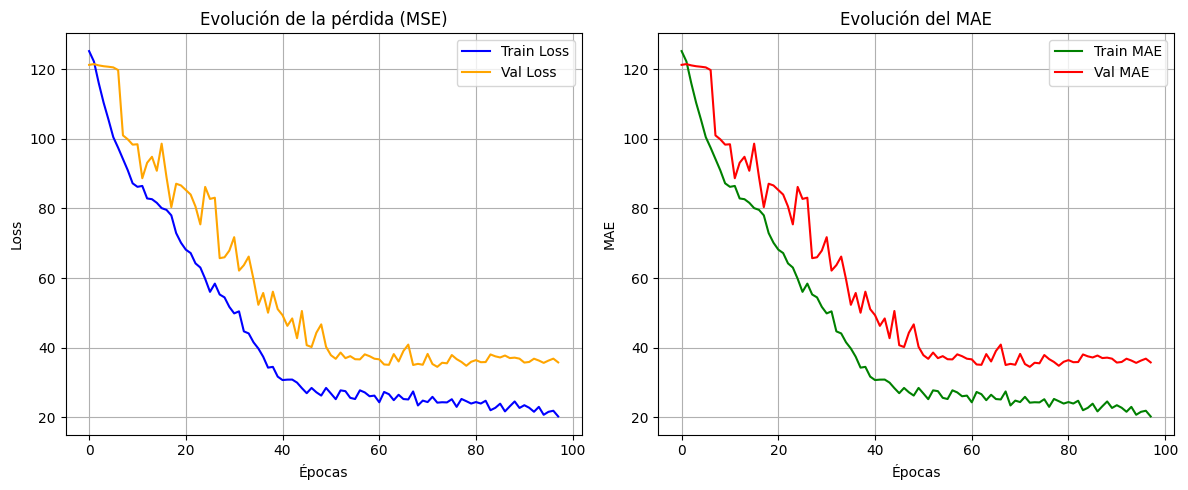

2025-05-26 23:16:23.554481: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:16:23.807808: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:16:26.195298: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:16:26.452158: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:16:27.473725: E external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 1:45 105s/step

2025-05-26 23:18:03.895806: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:18:04.051878: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:18:04.782132: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:18:05.022146: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 23:18:05.603332: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 115s 10s/step
MAE: 32.01 | MSE: 1628.04 | R²: 0.50


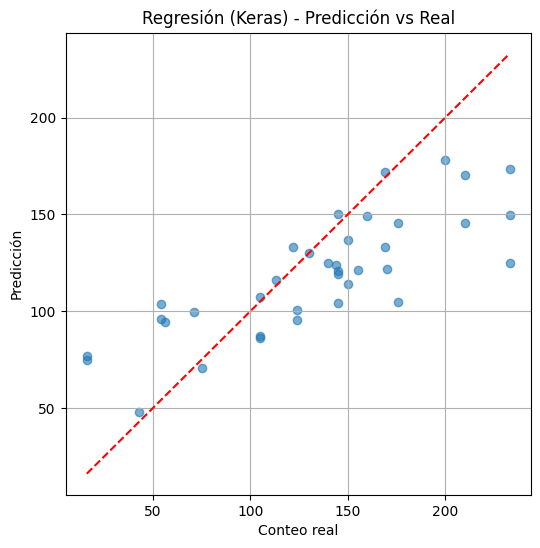

In [5]:
base_model = tf.keras.applications.EfficientNetB5(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [7]:
MODEL_PATH = '/home/quirogaalu/TFG/models/EfficientNetB5.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/EfficientNetB5.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/EfficientNetB5.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/EfficientNetB5.keras


## CountNet (VGG16 + GAP)

In [4]:
from tensorflow.keras.applications.vgg16 import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img) #
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


In [5]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # Puedes poner False para evitar fine-tuning

# Bloque 2 y 3: GAP + fully connected layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1)  # Salida: estimación de conteo
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='mse',
    metrics=['mae']
)

model.summary()


I0000 00:00:1748167560.596249 2281415 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748167560.597390 2281415 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 20, 20, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 14,879,041 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

from tensorflow.keras.applications.vgg16 import preprocess_input

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
x_test = preprocess_input(x_test)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200


I0000 00:00:1748167569.143895 2281572 service.cc:152] XLA service 0x790c3401a920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748167569.143911 2281572 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748167569.143912 2281572 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-25 12:06:09.183280: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748167569.443952 2281572 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-25 12:06:09.686507: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[4,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,640,640]{3,2,1,0} %bitcast.10575, f32[64,3,3,3]{3,2,1,0} %bitc

  1/107 ━━━━━━━━━━━━━━━━━━━━ 31:43 18s/step - loss: 13143.6045 - mae: 112.4172

I0000 00:00:1748167585.929281 2281572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 17058.2031 - mae: 118.1019

2025-05-25 12:06:47.995580: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[4,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,640,640]{3,2,1,0} %bitcast.603, f32[64,3,3,3]{3,2,1,0} %bitcast.610, f32[64]{0} %bitcast.612), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 12:06:48.381941: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_p

107/107 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 17027.3457 - mae: 117.9541 - val_loss: 4139.0229 - val_mae: 55.8597 - learning_rate: 1.0000e-06
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - loss: 5595.7222 - mae: 59.9167 - val_loss: 3929.6660 - val_mae: 53.5009 - learning_rate: 1.0000e-06
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - loss: 5128.0371 - mae: 58.4648 - val_loss: 4102.5459 - val_mae: 53.8254 - learning_rate: 1.0000e-06
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - loss: 4341.0747 - mae: 53.0668 - val_loss: 3858.8977 - val_mae: 51.9300 - learning_rate: 1.0000e-06
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - loss: 4515.8906 - mae: 54.8476 - val_loss: 3822.2102 - val_mae: 51.3950 - learning_rate: 1.0000e-06
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - loss: 4117.3994 - mae: 52.2430 - val_loss: 3807.2478 - val_mae: 51.3635 - learning_rate: 1.0000e-06
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - loss

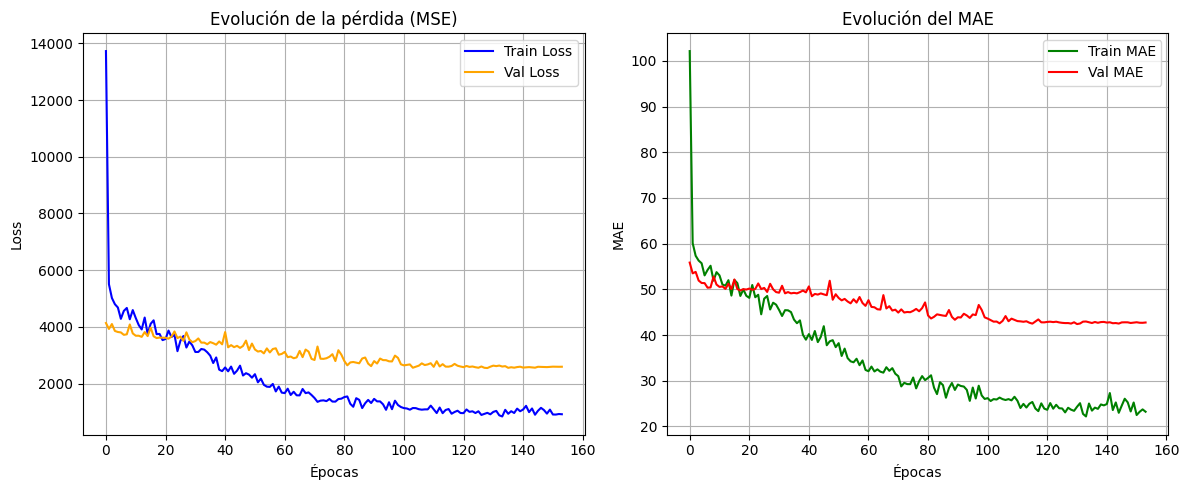

In [7]:
# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2025-05-25 13:05:55.781244: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,640,640]{3,2,1,0} %bitcast.507, f32[64,3,3,3]{3,2,1,0} %bitcast.514, f32[64]{0} %bitcast.516), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 13:05:58.214362: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm

1/2 ━━━━━━━━━━━━━━━━━━━━ 23s 24s/step

2025-05-25 13:06:19.328688: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[5,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,640,640]{3,2,1,0} %bitcast.507, f32[64,3,3,3]{3,2,1,0} %bitcast.514, f32[64]{0} %bitcast.516), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 13:06:19.802713: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_p

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step
MAE: 38.47 | MSE: 2626.33 | R²: 0.19


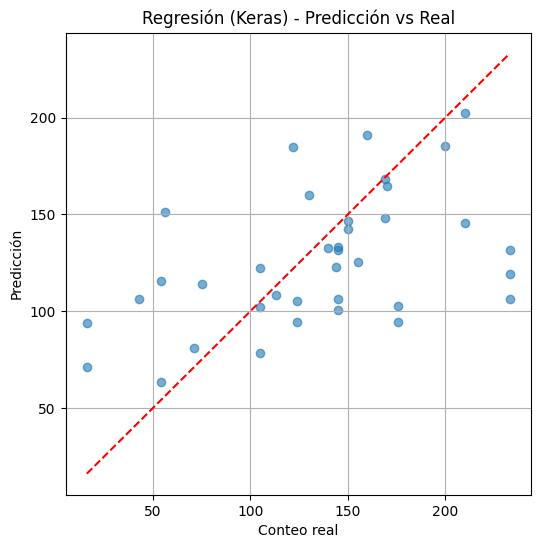

In [8]:
y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [12]:
MODEL_PATH = '/home/quirogaalu/TFG/models/CountNet.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/CountNet.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/CountNet.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/CountNet.keras


## VGG19

In [4]:
from tensorflow.keras.applications.vgg19 import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img) #
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748174893.351387 2303088 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748174893.352580 2303088 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748174894.057753 2303243 service.cc:152] XLA service 0x74a800004330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748174894.057767 2303243 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748174894.057769 2303243 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-25 14:08:14.062834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1748174897.773842 2303243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 20, 20, 512)    │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,177 (76.64 MB)

 Trainable params: 20,090,177 (76.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-05-25 14:08:20.690233: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.48 = (f32[4,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,640,640]{3,2,1,0} %bitcast.8804, f32[64,3,3,3]{3,2,1,0} %bitcast.8811, f32[64]{0} %bitcast.9927), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg19_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 14:08:20.989084: I external/local_xla/xla/service/gpu/autotuning/conv_algorith

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 9923.4365 - mae: 79.9854

2025-05-25 14:09:04.069892: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.48 = (f32[4,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,640,640]{3,2,1,0} %bitcast.660, f32[64,3,3,3]{3,2,1,0} %bitcast.667, f32[64]{0} %bitcast.669), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg19_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 14:09:04.380756: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_p

107/107 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - loss: 9887.1738 - mae: 79.8105 - val_loss: 3881.9014 - val_mae: 53.2108 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 260ms/step - loss: 3967.7722 - mae: 49.7907 - val_loss: 3301.6143 - val_mae: 47.2966 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - loss: 3399.3831 - mae: 45.7852 - val_loss: 3634.5015 - val_mae: 48.0852 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - loss: 3034.6030 - mae: 43.3262 - val_loss: 3047.3965 - val_mae: 45.1488 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - loss: 2812.7676 - mae: 42.1936 - val_loss: 2679.3684 - val_mae: 40.5995 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - loss: 2622.9692 - mae: 40.6213 - val_loss: 3240.8777 - val_mae: 46.0897 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - loss: 

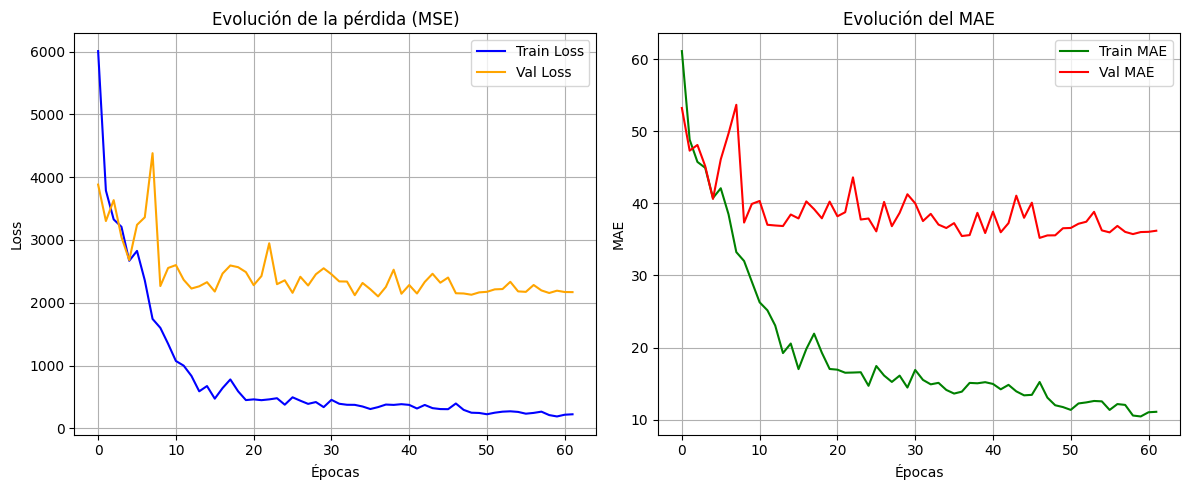

2025-05-25 14:37:53.973794: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.48 = (f32[32,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,640,640]{3,2,1,0} %bitcast.564, f32[64,3,3,3]{3,2,1,0} %bitcast.571, f32[64]{0} %bitcast.573), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg19_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 14:37:56.495040: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm

1/2 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step

2025-05-25 14:38:17.544896: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.48 = (f32[5,64,640,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,640,640]{3,2,1,0} %bitcast.564, f32[64,3,3,3]{3,2,1,0} %bitcast.571, f32[64]{0} %bitcast.573), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/vgg19_1/block1_conv1_1/convolution" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-25 14:38:17.939311: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_p

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step
MAE: 40.65 | MSE: 2448.04 | R²: 0.25


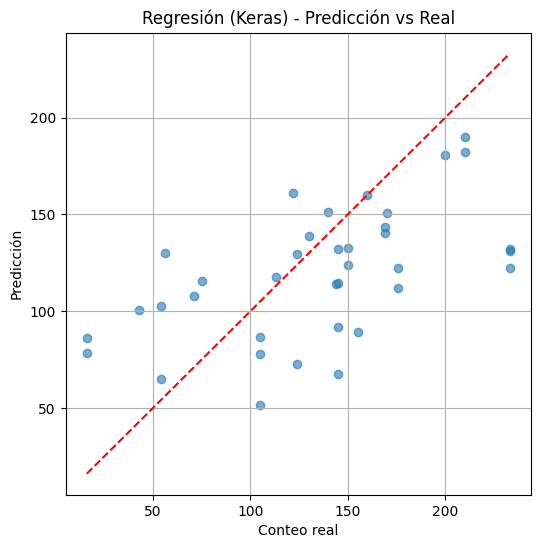

In [5]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/VGG19.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/VGG19.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/VGG19.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/VGG19.keras


## DenseNet121

In [4]:
from tensorflow.keras.applications.densenet import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img) #
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748178592.053520 2312698 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748178592.054730 2312698 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748178594.181774 2312850 service.cc:152] XLA service 0x7ce2bc086030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748178594.181788 2312850 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748178594.181790 2312850 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-25 15:09:54.242650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


I0000 00:00:1748178605.178681 2312850 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 20, 20, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 7,085,185 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/200


2025-05-25 15:10:25.676974: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:10:25.919570: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:10:26.394101: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:10:26.625127: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:10:27.089958: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 19417.1309 - mae: 126.8540

2025-05-25 15:12:53.792929: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:12:54.035803: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:12:54.487074: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:12:54.718033: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:12:55.170476: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 184s 311ms/step - loss: 19412.9316 - mae: 126.8413 - val_loss: 18260.3652 - val_mae: 121.2365 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 17914.5020 - mae: 121.6769 - val_loss: 17641.4141 - val_mae: 118.7536 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 16983.7852 - mae: 117.6508 - val_loss: 16531.2461 - val_mae: 113.9916 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 16331.8096 - mae: 114.5037 - val_loss: 15516.1406 - val_mae: 109.4506 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 16628.8262 - mae: 115.0643 - val_loss: 14679.2910 - val_mae: 105.6732 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 14980.5137 - mae: 110.6184 - val_loss: 13714.1592 - val_mae: 101.4212 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━

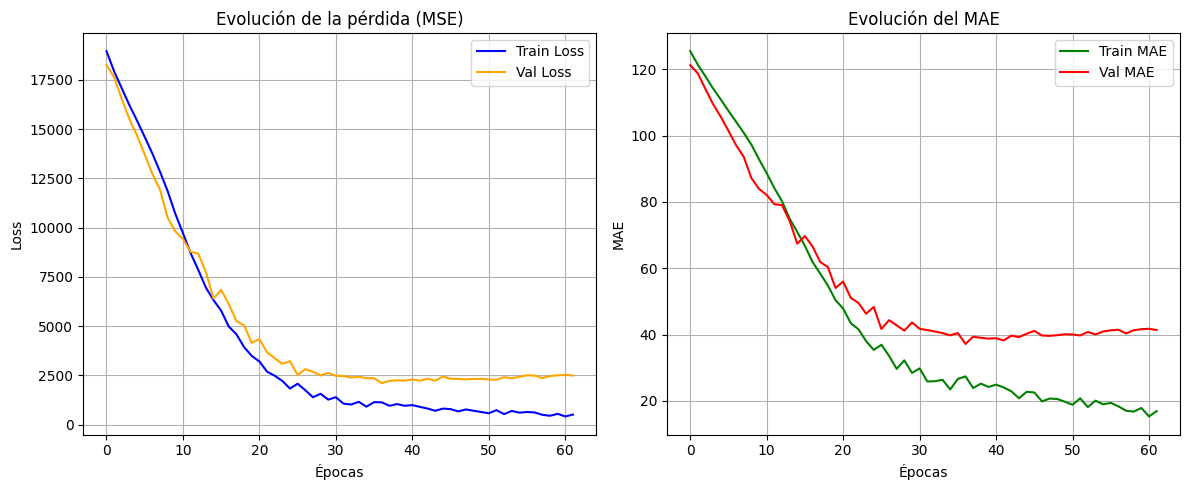

2025-05-25 15:25:44.579335: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:25:44.842470: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:25:45.712330: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:25:45.962017: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:25:46.809191: E external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step

2025-05-25 15:26:10.218045: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:26:10.465193: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:26:10.953205: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:26:11.189377: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:26:11.672952: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 19s/step
MAE: 47.95 | MSE: 3238.48 | R²: 0.01


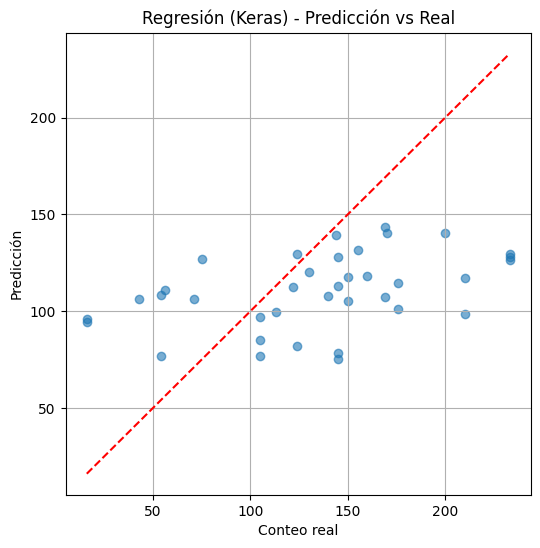

In [5]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/DenseNet121.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/DenseNet121.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/DenseNet121.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/DenseNet121.keras


## InceptionV3

In [4]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img) #
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748179928.063973 2321738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748179928.065299 2321738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748179929.760647 2321871 service.cc:152] XLA service 0x72853c016a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748179929.760662 2321871 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748179929.760664 2321871 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-25 15:32:09.798246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1748179934.322678 2321871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 18, 18, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 22,030,753 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Epoch 1/200


2025-05-25 15:32:27.483570: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:32:27.716501: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:32:28.555589: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:32:28.819976: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:32:29.022414: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 18571.6621 - mae: 123.2145

2025-05-25 15:33:06.611073: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:33:06.845668: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:33:07.634479: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:33:07.898853: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:33:08.175753: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - loss: 18570.8945 - mae: 123.2187 - val_loss: 16860.2051 - val_mae: 115.2633 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 17731.4277 - mae: 120.6230 - val_loss: 15559.3213 - val_mae: 109.7886 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 15894.6836 - mae: 115.5245 - val_loss: 13989.4434 - val_mae: 103.7697 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 13619.2500 - mae: 104.7834 - val_loss: 13551.4141 - val_mae: 102.6652 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 12888.4990 - mae: 103.4064 - val_loss: 13784.6299 - val_mae: 103.7294 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 12055.1504 - mae: 101.2541 - val_loss: 11611.7793 - val_mae: 93.9789 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 

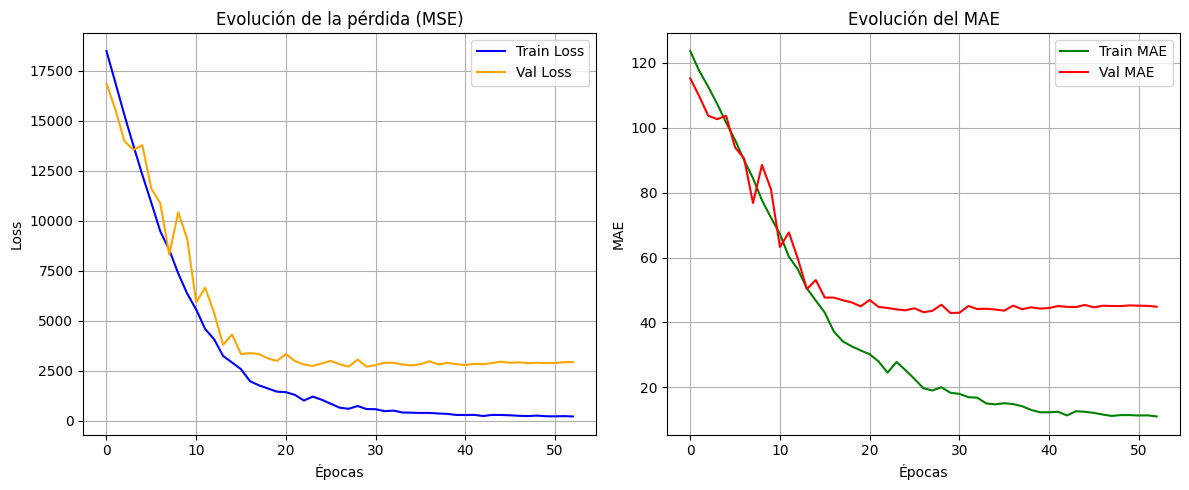

2025-05-25 15:43:30.409330: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:30.659449: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:32.341488: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:32.493239: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:32.779673: E external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step

2025-05-25 15:43:44.764491: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:45.002401: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:45.923436: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:46.192244: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:43:46.401990: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step
MAE: 47.48 | MSE: 3274.83 | R²: -0.00


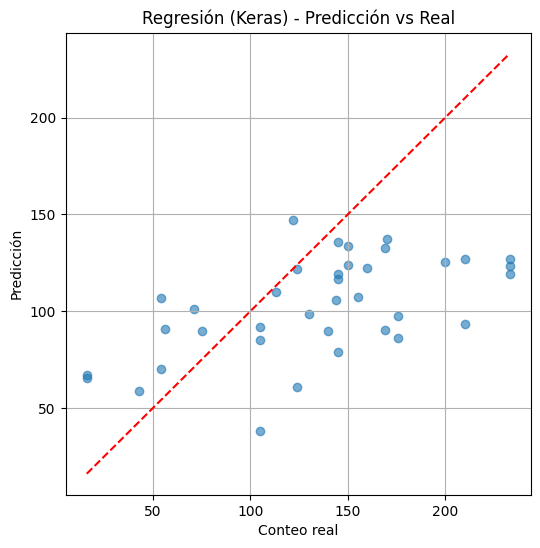

In [5]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/InceptionV3.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/InceptionV3.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/InceptionV3.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/InceptionV3.keras


## ConvNeXtBase

In [4]:
IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img) #/ 255.0
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748183652.731054 2342164 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748183652.732284 2342164 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748183654.677309 2342315 service.cc:152] XLA service 0x7b5da0014320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748183654.677330 2342315 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748183654.677333 2342315 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-25 16:34:14.733663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1748183656.457927 2342315 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 20, 20, 1024)   │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,697,793 (334.54 MB)

 Trainable params: 87,697,793 (334.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-05-25 16:34:32.914471: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:34:33.152045: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:34:33.641248: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:34:33.766256: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:34:34.030045: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 533ms/step - loss: 16899.3633 - mae: 116.0427 - val_loss: 10087.3389 - val_mae: 85.6541 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 501ms/step - loss: 9638.9326 - mae: 83.5193 - val_loss: 8367.2158 - val_mae: 78.4916 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - loss: 8266.9512 - mae: 77.9154 - val_loss: 7392.3262 - val_mae: 74.4269 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - loss: 7487.0308 - mae: 72.5402 - val_loss: 6654.9175 - val_mae: 71.3724 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - loss: 7280.7334 - mae: 71.3173 - val_loss: 6030.8662 - val_mae: 68.4861 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - loss: 5496.7046 - mae: 62.6078 - val_loss: 5490.3442 - val_mae: 65.6721 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 505ms/step - los

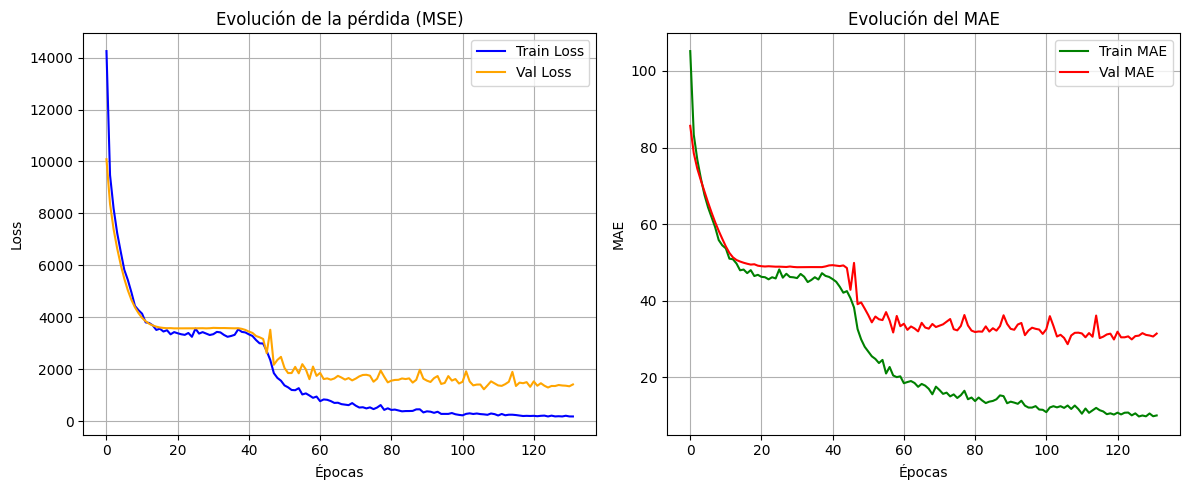

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
MAE: 34.67 | MSE: 2028.34 | R²: 0.38


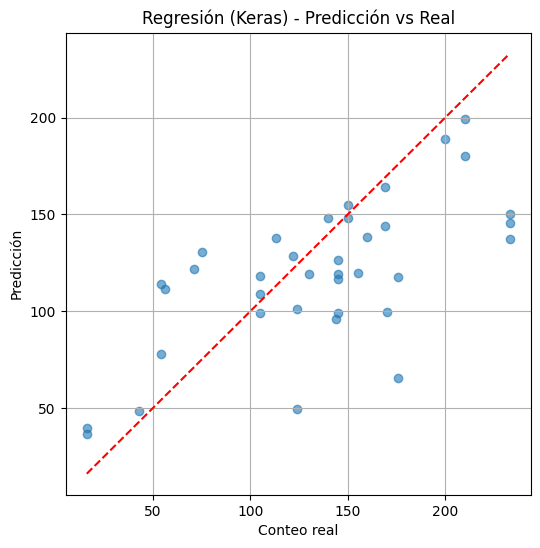

In [5]:
from tensorflow.keras.applications import ConvNeXtBase 

base_model = ConvNeXtBase(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/ConvNeXtBase.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/ConvNeXtBase.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/ConvNeXtBase.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/ConvNeXtBase.keras


## Xception

In [4]:
from tensorflow.keras.applications.xception import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img)
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748181190.931497 2329571 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748181190.932670 2329571 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748181192.117093 2329716 service.cc:152] XLA service 0x706a40001ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748181192.117112 2329716 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748181192.117114 2329716 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-25 15:53:12.143599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1748181195.176087 2329716 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 20, 20, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,123,881 (80.58 MB)

 Trainable params: 21,069,353 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/200


2025-05-25 15:53:24.628299: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:24.939500: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:25.148666: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:25.317217: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:25.633930: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 19153.5098 - mae: 126.0835

2025-05-25 15:53:57.865663: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:58.028155: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:58.313260: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:58.439323: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 15:53:58.731232: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - loss: 19150.8359 - mae: 126.0744 - val_loss: 17556.8027 - val_mae: 118.2191 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 18776.9766 - mae: 125.3511 - val_loss: 16859.8223 - val_mae: 115.3278 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 16908.5742 - mae: 117.6086 - val_loss: 16175.6943 - val_mae: 112.6829 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 15707.5381 - mae: 115.7556 - val_loss: 15064.6104 - val_mae: 108.5895 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 13747.5801 - mae: 107.6663 - val_loss: 14537.3662 - val_mae: 106.5799 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 13227.1816 - mae: 106.1663 - val_loss: 14239.0225 - val_mae: 105.7948 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━

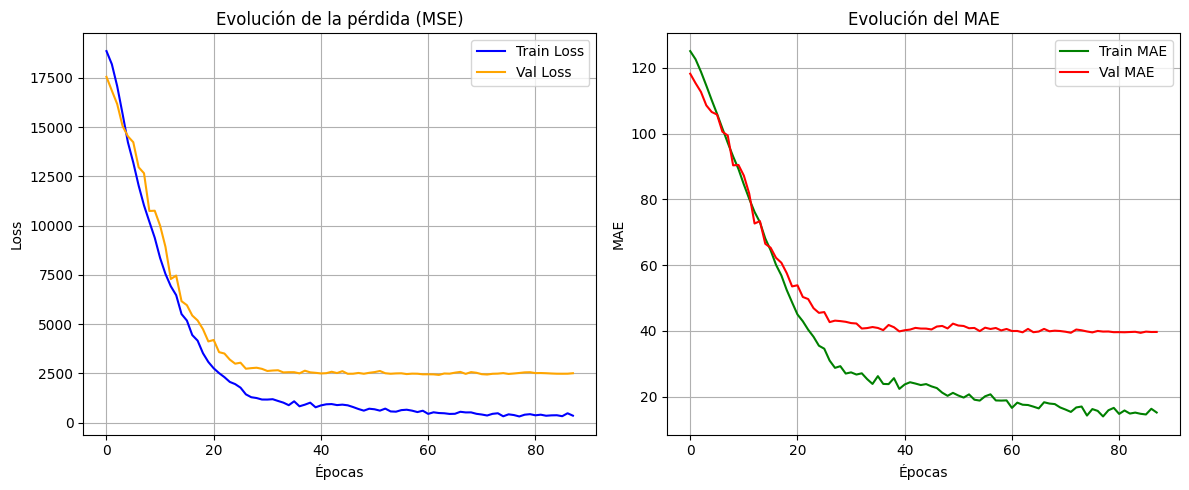

2025-05-25 16:19:01.627831: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng2{k2=1,k3=0} for conv %cudnn-conv.78 = (f32[32,128,317,317]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,317,317]{3,2,1,0} %bitcast.4491, f32[128,1,3,3]{3,2,1,0} %bitcast.4495), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="sequential_1/xception_1/block2_sepconv2_1/separable_conv2d/depthwise" source_file="/home/quirogaalu/miniconda3/envs/tfg/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-25 16:19:01.847766: E external/local_xla/xla/service/slow_operation_alarm.cc:140] 

1/2 ━━━━━━━━━━━━━━━━━━━━ 2:33 154s/step

2025-05-25 16:21:31.803684: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:21:31.986701: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:21:32.349062: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:21:32.481778: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-25 16:21:32.840782: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step
MAE: 40.27 | MSE: 2390.24 | R²: 0.27


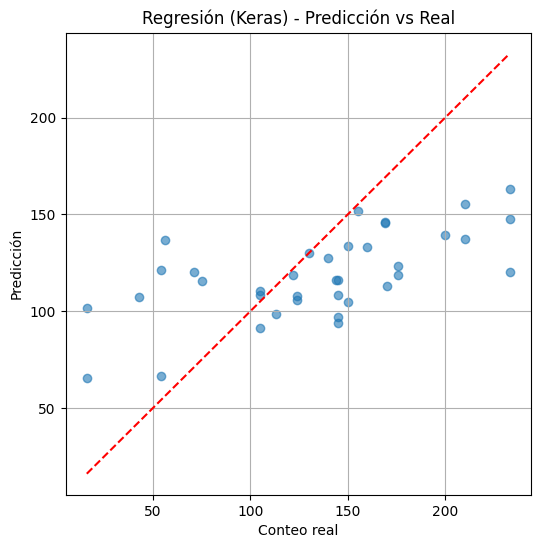

In [5]:
from tensorflow.keras.applications import Xception

base_model = Xception(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/Xception.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/Xception.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/Xception.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/Xception.keras


## NASNetLarge

In [4]:
from tensorflow.keras.applications.nasnet import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img)
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748249258.122875 2387539 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748249258.124021 2387539 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748249262.857456 2387696 service.cc:152] XLA service 0x768b0c03af60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748249262.857473 2387696 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748249262.857475 2387696 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-26 10:47:42.946755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


I0000 00:00:1748249271.263968 2387696 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_large (Functional)       │ (None, 20, 20, 4032)   │    84,916,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 4032)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       516,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,433,171 (325.90 MB)

 Trainable params: 85,236,503 (325.15 MB)

 Non-trainable params: 196,668 (768.23 KB)

Epoch 1/200


2025-05-26 10:48:42.828915: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:48:43.058947: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:48:43.264190: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:48:43.397207: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:48:43.770316: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 18956.6895 - mae: 124.1125

2025-05-26 10:50:13.344337: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:50:13.577719: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:50:13.778641: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:50:13.914552: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 10:50:14.287100: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 148s 589ms/step - loss: 18946.5156 - mae: 124.0846 - val_loss: 17697.7031 - val_mae: 118.7560 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - loss: 15602.7539 - mae: 111.6528 - val_loss: 16676.4805 - val_mae: 114.4191 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 49s 462ms/step - loss: 7923.0640 - mae: 79.4885 - val_loss: 15519.2891 - val_mae: 109.1171 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 49s 462ms/step - loss: 4905.6758 - mae: 61.2515 - val_loss: 14196.9951 - val_mae: 102.4548 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 50s 463ms/step - loss: 3085.9771 - mae: 46.8587 - val_loss: 13095.9814 - val_mae: 97.4414 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 50s 463ms/step - loss: 1624.1165 - mae: 32.5816 - val_loss: 11956.2842 - val_mae: 92.0557 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 50s 463m

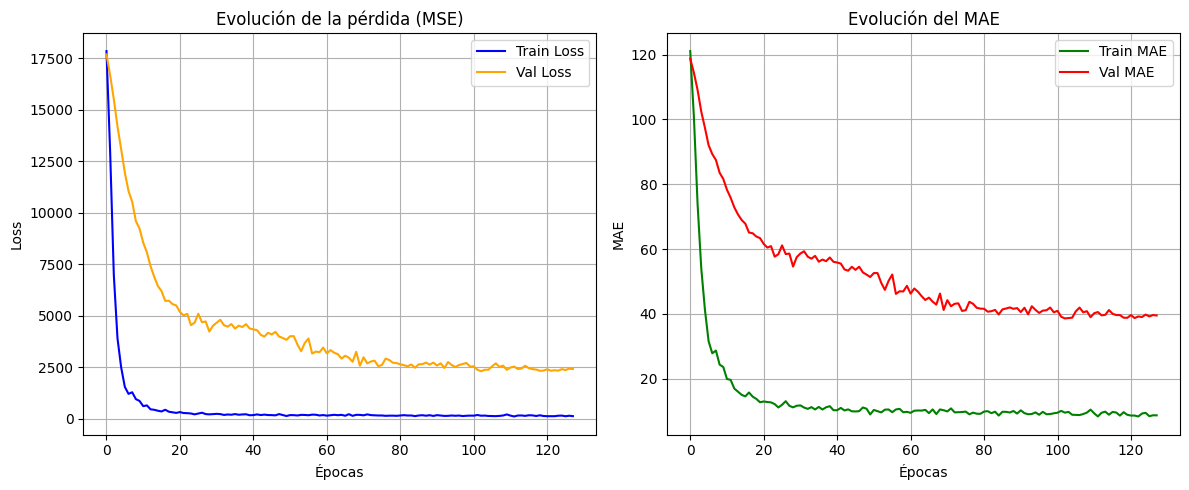

2025-05-26 12:35:21.261525: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:21.507641: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:22.249247: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:22.433226: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:22.916463: E external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 41s 42s/step

2025-05-26 12:35:59.284609: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:59.519368: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:59.736869: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:35:59.876095: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 12:36:00.256994: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step
MAE: 38.24 | MSE: 2323.89 | R²: 0.29


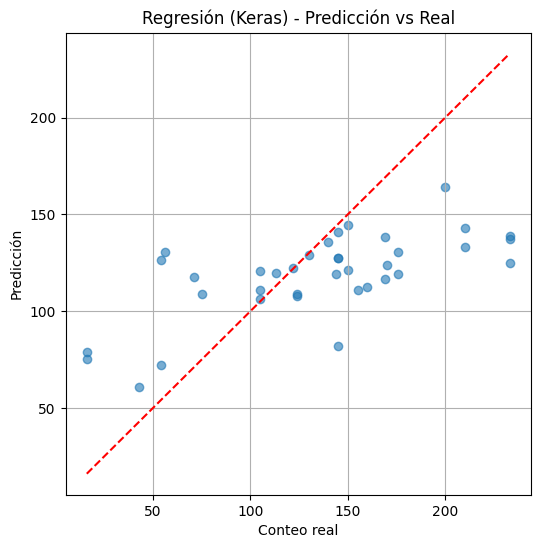

In [5]:
from tensorflow.keras.applications import NASNetLarge

base_model = NASNetLarge(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/NASNetLarge_2.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/NASNetLarge_2.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/NASNetLarge_2.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/NASNetLarge_2.keras


## ResNet152

In [4]:
from tensorflow.keras.applications.resnet import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img)
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748265134.635319 2407255 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748265134.636557 2407255 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748265137.966427 2407403 service.cc:152] XLA service 0x79ee08002f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748265137.966449 2407403 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748265137.966452 2407403 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-26 15:12:18.063876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1748265142.400790 2407403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 20, 20, 2048)   │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,633,345 (223.67 MB)

 Trainable params: 58,481,921 (223.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

Epoch 1/200


2025-05-26 15:12:54.054370: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:12:54.321092: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:12:54.703686: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:12:54.933947: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:12:54.982336: I external/local_xla/xla/service

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 16999.5059 - mae: 118.6133

2025-05-26 15:13:50.358277: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:13:50.626542: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:13:51.014493: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:13:51.247013: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:13:51.704718: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 92s 371ms/step - loss: 17002.1895 - mae: 118.6143 - val_loss: 12063.1963 - val_mae: 93.2016 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 286ms/step - loss: 13429.5908 - mae: 102.8236 - val_loss: 6090.3804 - val_mae: 66.8808 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - loss: 6950.9609 - mae: 72.3173 - val_loss: 6506.5889 - val_mae: 67.9337 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step - loss: 4552.2476 - mae: 56.8915 - val_loss: 5050.9404 - val_mae: 60.1815 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step - loss: 2633.8477 - mae: 42.6495 - val_loss: 4086.6196 - val_mae: 54.1867 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step - loss: 1890.1686 - mae: 36.0868 - val_loss: 4840.6460 - val_mae: 57.6252 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - l

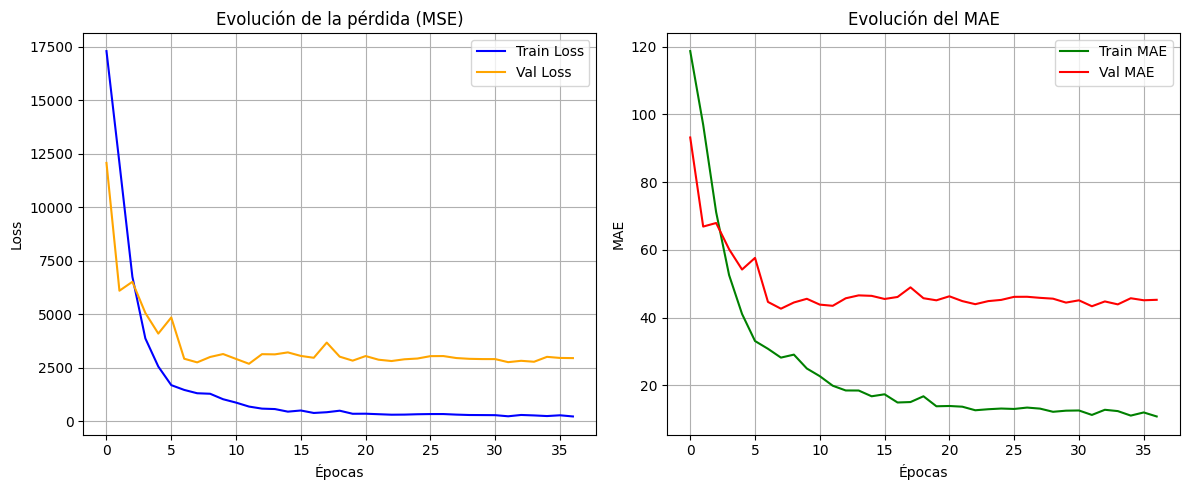

2025-05-26 15:32:35.826661: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:36.125963: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:36.611710: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:36.857251: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:37.009980: I external/local_xla/xla/service

1/2 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

2025-05-26 15:32:47.020188: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:47.292283: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:47.683070: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:47.918014: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:32:47.968934: I external/local_xla/xla/service

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step
MAE: 41.34 | MSE: 2463.69 | R²: 0.24


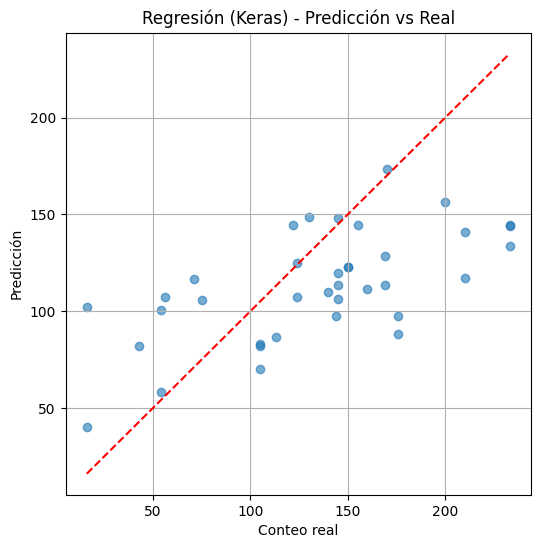

In [5]:
from tensorflow.keras.applications import ResNet152

base_model = ResNet152(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/ResNet152.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/ResNet152.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/ResNet152.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/ResNet152.keras


## InceptionResNetV2

In [4]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

IMG_SIZE = 640

def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['ruta_imagen']).convert('RGB') #.resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            img = preprocess_input(img)
            images.append(img)
            labels.append(row['conteo_real'])
        except Exception as e:
            print(f"Error cargando imagen {row['ruta_imagen']}: {e}")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)
x_test, y_test = load_images_and_labels(test_df)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (428, 640, 640, 3), y_train shape: (428,)
x_val shape: (35, 640, 640, 3), y_val shape: (35,)
x_test shape: (37, 640, 640, 3), y_test shape: (37,)


I0000 00:00:1748267164.143162 2412914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22742 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1748267164.144336 2412914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22777 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1748267167.609454 2413065 service.cc:152] XLA service 0x7486cc0c7590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748267167.609470 2413065 service.cc:160]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1748267167.609472 2413065 service.cc:160]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-05-26 15:46:07.699994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1748267173.259408 2413065 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 18, 18, 1536)   │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,533,601 (208.03 MB)

 Trainable params: 54,473,057 (207.80 MB)

 Non-trainable params: 60,544 (236.50 KB)

Epoch 1/200


2025-05-26 15:46:43.115577: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:46:43.348836: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:46:44.186439: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:46:44.450133: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:46:44.712680: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 18873.2383 - mae: 124.3198

2025-05-26 15:47:44.838686: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:47:45.073570: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:47:45.864871: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:47:46.129956: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 15:47:46.397590: E external/local_xla/xla/stream_

107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 371ms/step - loss: 18870.5586 - mae: 124.3169 - val_loss: 17288.4277 - val_mae: 117.0129 - learning_rate: 1.0000e-05
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step - loss: 17179.3379 - mae: 118.4796 - val_loss: 16412.1270 - val_mae: 114.0295 - learning_rate: 1.0000e-05
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - loss: 15335.6113 - mae: 112.7344 - val_loss: 16622.5137 - val_mae: 116.0177 - learning_rate: 1.0000e-05
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - loss: 13614.7324 - mae: 105.8471 - val_loss: 15281.7373 - val_mae: 111.3541 - learning_rate: 1.0000e-05
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - loss: 11919.9082 - mae: 100.5590 - val_loss: 12847.1416 - val_mae: 100.6617 - learning_rate: 1.0000e-05
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - loss: 10571.4883 - mae: 93.7249 - val_loss: 10581.3076 - val_mae: 91.3998 - learning_rate: 1.0000e-05
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 2

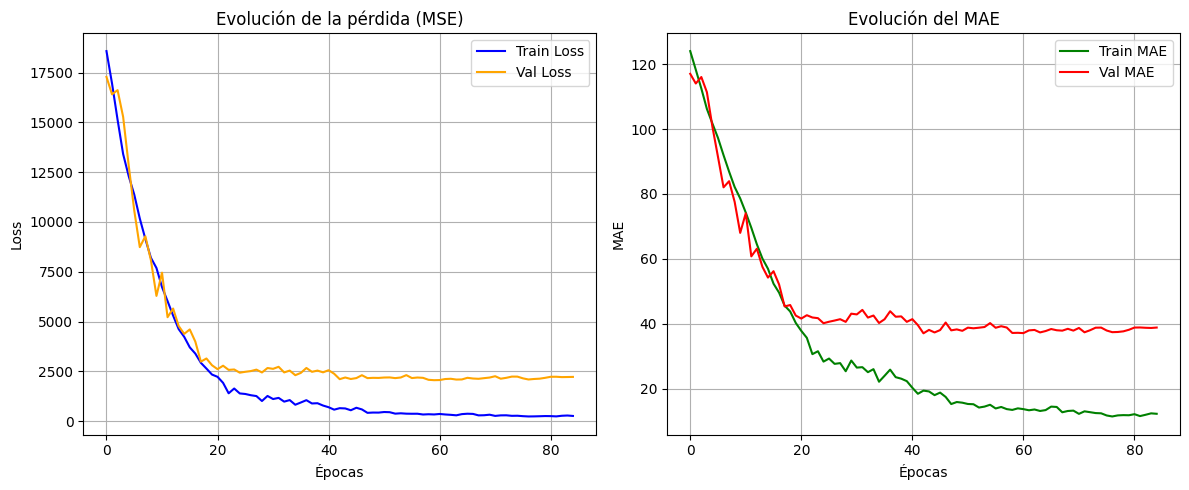

2025-05-26 16:25:24.749551: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:24.999579: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:26.659082: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:26.815542: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:27.102729: E external/local_xla/xla/stream_

1/2 ━━━━━━━━━━━━━━━━━━━━ 21s 22s/step

2025-05-26 16:25:42.829987: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:43.067993: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:44.014349: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:44.282750: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-26 16:25:44.554734: E external/local_xla/xla/stream_

2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 12s/step
MAE: 38.35 | MSE: 2234.95 | R²: 0.31


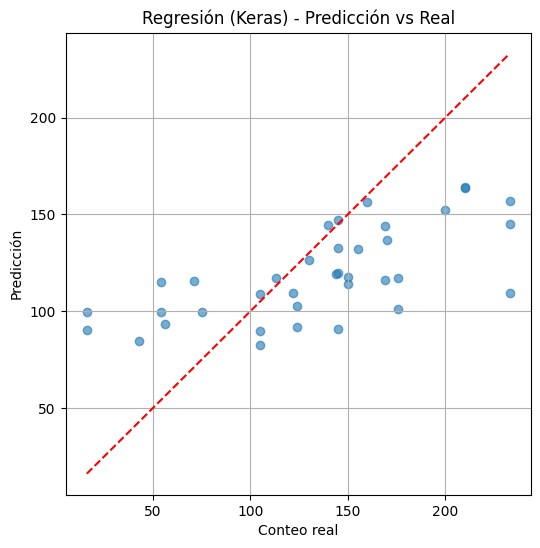

In [5]:
from tensorflow.keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # fine-tuning activado

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # regresión
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='mse',
              metrics=['mae'])

_ = model.predict(np.zeros_like(x_test[:1]))

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Reduce LR si no hay mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=4,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# VISUALIZACIÓN DEL ENTRENAMIENTO

import matplotlib.pyplot as plt

# Gráfico de pérdida (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución del MAE')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Conteo real")
plt.ylabel("Predicción")
plt.title("Regresión (Keras) - Predicción vs Real")
plt.grid(True)
plt.show()

In [6]:
MODEL_PATH = '/home/quirogaalu/TFG/models/InceptionResNetV2.h5'

# Guardar el modelo .h5
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")


MODEL_PATH = '/home/quirogaalu/TFG/models/InceptionResNetV2.keras'

# Guardar el modelo .keras
model.save(MODEL_PATH)
print(f"✅ Modelo guardado en: {MODEL_PATH}")

✅ Modelo guardado en: /home/quirogaalu/TFG/models/InceptionResNetV2.h5
✅ Modelo guardado en: /home/quirogaalu/TFG/models/InceptionResNetV2.keras
